<img style="float: left;" alt="Drawing" src="./figures/3Di_beeldmerk_RGB.png" width="100"/>

## From starting a 3Di-simulation to downloading and analysing the results in a jupyter notebook

Welcome! In this notebook we will show you how to start a <a href="https://3diwatermanagement.com/">3Di</a>-simulation in a jupyter notebook by using the API-v3. In addition, we will show you how to download, visualize and analyse the results of the 3Di-simulation.

The following steps will be taken according to an example of an 3Di model:
- **step 1:** Creating a 3Di-simulation by using the threedi-api
- **step 2:** Adding events to this 3Di-simulation by using the threedi-api
- **step 3:** Running the 3Di-simulation by using the threedi-api
- **step 4:** Downloading the results of the 3Di-simulation
- **step 5:** Analysing the results of the simulation

**Step 1: Starting a 3Di-simulation by using the threedi-api**

Importing all required packages:

In [1]:
from datetime import datetime
from getpass import getpass
import pandas as pd
import json
from threedi_api_client.threedi_api_client import ThreediApiClient
from threedi_api_client.api import ThreediApi
from threedi_api_client.versions import V3Api
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import requests
from pathlib import Path
import matplotlib.pylab as pylab
import numpy as np

Set some figures plot parameters:

In [2]:
plt.style.use('bmh')

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 15),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params) 

Provide your credentials to connect to the threedi-api:

In [3]:
env_file = r"C:\Users\olof.baltus\Documents\authentication_olof.env"
api_client: V3Api = ThreediApi(env_file)

Check the connection with your provided credentials:

In [4]:
try:
    user = api_client.auth_profile_list()
except ApiException as e:
    print("Oops, something went wrong. Maybe you made a typo?")
else:
    print(f"Successfully logged in as {user.username}!")

Successfully logged in as olof.baltus!


1.3  In order to run a simulation you need a threedi-model. Let's see which threedi-models are available:

In [5]:
models = api_client.threedimodels_list(limit=10)  # limit to the first 10 results
for model in models.results:
    print(f"{model.name}")

aalbeek-wijnandsrade - Aalbeek-Wijnandsrade_t_compleet (1) #2
Isiolo_test_tristan #19
Zundert integraal - maatregel - 05102022 #1
lakeMeadTestJulian #1
Lichtenvoorde #17
Isiolo_test_tristan #18
scheumerbeek_2d #32
Hoofdbemalingsgebied met aanpassingen rondom Skivijver #11
aalbeek-wijnandsrade - Aalbeek-Wijnandsrade_t_landelijk (2) #0
wrap2022_beinan #28


In this notebook we will use one revision of the  3Di-model "BWN Schermer", and we can look up this model by using the following query:

In [6]:
models = api_client.threedimodels_list(name__icontains='bwn_schermer_1d2d_glg')
my_model =models.results[0]
my_model

{'breach_count': '0',
 'description': '',
 'disabled': False,
 'epsg': 28992,
 'extent_one_d': {'coordinates': [[4.74634612870575, 52.55681213460283],
                                  [4.888587810013935, 52.63865715029159]],
                  'type': 'LineString'},
 'extent_two_d': {'coordinates': [[4.746025226172878, 52.55657076725741],
                                  [4.889009767284062, 52.63922057415141]],
                  'type': 'LineString'},
 'extent_zero_d': None,
 'id': 51041,
 'inp_success': True,
 'inpy_version': '-',
 'is_valid': True,
 'lines_count': 107686,
 'model_ini': ' ',
 'name': 'bwn-schermer - bwn_schermer_1d2d_glg (5) #20',
 'nodes_count': 53383,
 'repository_slug': 'bwn-schermer-bwn_schermer_1d2d_glg-5',
 'revision': 'https://api.3di.live/v3/schematisations/3897/revisions/28618/',
 'revision_commit_date': '2020-02-26T09:50:00Z',
 'revision_hash': '',
 'revision_id': 28618,
 'revision_number': '20',
 'schematisation_id': 3897,
 'schematisation_name': 'bwn-sche

The 3Di-model of BWN Schermer:

<img style="float: left;" alt="Drawing" src="./figures/3di_model_bwn_schermer.PNG" width="700"/> 

Now that we have a model we are almost ready to create the simulation. However, first we'll need to get an organisation under which's name we will run the simulation.

Let's see which organisations are available within my user account:

In [7]:
organisations = api_client.organisations_list()


for organisation in organisations.results:
    print(f"{organisation.name}: {organisation.unique_id}")

3Di Global: 93bcc95f40d34b77919dda9374ee866
3Di test: bf5b7a0bc3504489a4f0191e6d9e87f7
Academic License: 086a4dfe6fbe43698e4a320c5007c053
Almere: 83280e0e21004a728f5f78cc6abaedfb
Arcadis: f796974ba7184066b2681403db4bb2ff
BAM_Schiphol: 06afd9a3f2234a18a1970da59013707d
bar-organisatie: 92be5a6ad66540c8b9263964c22b0542
Beemster: 964a9ee0d95246748bc270a05fc0f458
Binh Minh Water & Environment Company: d61bc83835f641a4966129e366db14fc
Binnenmaas: ccaa44c7d53646e3a806e4075dd00833


In this example we use the organisation from N&S Demo:

organisation_uuid = "a1993f6e13564e9687ae03a3604463f9"

In [8]:
organisation_uuid = "a1993f6e13564e9687ae03a3604463f9"

1.5 Let's create the simulation of the chosen model now, with this organisation uuid. Note that it will not run yet.

In [9]:
my_simulation_template = api_client.simulation_templates_list(simulation__threedimodel__id=my_model.id).results[0]
my_simulation = api_client.simulations_from_template(
        data={
            "template": my_simulation_template.id,
            "name": "demo_simulation_3dinotebook_schermer",
            "tags": ["demo_notebook_1"],
            "organisation": organisation_uuid,
            "start_datetime": datetime.now(),
            "duration": 3600 # in seconds, so we simulate for 1 hour
        }
    )

You can check the status of the simulation with the following api call:

In [10]:
#check the status of the simulation with:
status = api_client.simulations_status_list(my_simulation.id)
print(status)

{'created': datetime.datetime(2022, 10, 5, 14, 43, 38, 98173, tzinfo=tzutc()),
 'exit_code': None,
 'id': 450050,
 'name': 'created',
 'paused': None,
 'time': 0.0}


We can see the simulation has not started yet. The options at the name of the status can be: "created", "started" and "finished".

**Step 2: Adding events to this 3Di-simulation by using the threedi-api**

In the previous step we created a simulation for the 3Di model of rockflow. Several events can be added to this 3Di-simulation:

* initial waterlevels
* rain
* breaches
* laterals


In this step we create a simple constant rain event of 30 minutes with an offset of 5 minutes:

Now we add this constant rain event to our created simulation

In [11]:
api_client.simulations_events_rain_constant_create(    
    simulation_pk=my_simulation.id,   # the ID we got from our create call above
    data={
        "offset": 300,       # let the rain start after 5 minutes
        "duration": 1800,    # let the rain last for half an hour
        "value": 0.0006,     # not too extreme after all...;-)
        "units": "m/s",      # the only unit supported for now
    },
)

{'duration': 1800,
 'id': 25993,
 'offset': 300,
 'simulation': 'https://api.3di.live/v3/simulations/96486/',
 'uid': '945b2853-b47c-480d-ac75-a3430077e4cf',
 'units': 'm/s',
 'url': 'https://api.3di.live/v3/simulations/96486/events/rain/constant/25993/',
 'value': 0.0006}

2.3 We can get an overview of the added events to our 3Di-simulation by the following api-call:

In [12]:
events = api_client.simulations_events(my_simulation.id)
print(events.timeseriesrain)

[{'constant': True,
 'duration': 1800,
 'id': 25993,
 'interpolate': False,
 'offset': 300,
 'simulation': 'https://api.3di.live/v3/simulations/96486/',
 'uid': '945b2853-b47c-480d-ac75-a3430077e4cf',
 'units': 'm/s',
 'url': 'https://api.3di.live/v3/simulations/96486/events/rain/constant/25993/',
 'values': [[0.0, 0.0006], [1800.0, 0.0]]}]


So, we can indeed see here that we have only added the constant rain event to our 3di-simulation.

**Step 3: Running the 3Di-simulation by using the threedi-api**

We will now start our simulation with the constant rain event:

In [13]:
api_client.simulations_actions_create(my_simulation.id, data={"name": "start"})

{'compute_cluster': None,
 'duration': None,
 'max_rate': None,
 'name': 'start',
 'timeout': 300}

We can check the status of the 3Di-simulation with:

In [17]:
#check the status of the simulation with:
status = api_client.simulations_status_list(my_simulation.id)
print(status)

{'created': datetime.datetime(2022, 9, 23, 7, 15, 9, 79793, tzinfo=tzutc()),
 'exit_code': None,
 'id': 440037,
 'name': 'starting',
 'paused': None,
 'time': 0.0}


In the end we must see that our simulation has finished:

In [19]:
#check the status of the simulation with:
status = api_client.simulations_status_list(my_simulation.id)
print(status)

{'created': datetime.datetime(2022, 9, 23, 7, 19, 25, 28822, tzinfo=tzutc()),
 'exit_code': '1240 [finished]',
 'id': 440044,
 'name': 'finished',
 'paused': False,
 'time': 3600.0}


**Step 4: Downloading the results of  the 3Di-simulation**

When our simulation has finished, it is time to analyse the results of the 3Di-model. Before that, we have to download all the results of the simulation.

We select again the model and check if the status is finished:

In [20]:
status = api_client.simulations_status_list(my_simulation.id)

print(my_simulation)
print(f"status: {status}")
assert status.name == 'finished'

{'cloned_from': 'https://api.3di.live/v3/simulations/94125/',
 'compute_cluster': None,
 'created': 'now',
 'duration': 3600,
 'duration_humanized': '1 hours, 0 minutes, 0 seconds',
 'end_datetime': datetime.datetime(2022, 9, 23, 10, 14, 20, tzinfo=tzutc()),
 'id': 94239,
 'name': 'demo_simulation_3dinotebook_schermer',
 'organisation': 'a1993f6e13564e9687ae03a3604463f9',
 'organisation_name': 'N&S Demo',
 'slug': 'demo_simulation_3dinotebook_schermer-fec3c822-2659-4edb-8ba3-bec1afdd5b79',
 'start_datetime': datetime.datetime(2022, 9, 23, 9, 14, 20, tzinfo=tzutc()),
 'tags': ['demo_notebook_1'],
 'threedicore_version': None,
 'threedimodel': 'https://api.3di.live/v3/threedimodels/51041/',
 'threedimodel_id': 51041,
 'url': 'https://api.3di.live/v3/simulations/94239/',
 'user': 'olof.baltus',
 'uuid': 'fec3c822-2659-4edb-8ba3-bec1afdd5b79'}
status: {'created': datetime.datetime(2022, 9, 23, 7, 19, 25, 28822, tzinfo=tzutc()),
 'exit_code': '1240 [finished]',
 'id': 440044,
 'name': 'fini

If you began this script at step 4, after previously running a simulation, and you want to find and define this simulation. You can run the following code. 

Otherwise, you can skipt this part. 

In [21]:
my_simulation_name = 'demo_simulation_3dinotebook_schermer'
username = 'olof.baltus'

my_simulation = api_client.simulations_list(
    name=my_simulation_name, user__username=username
).results[0]

print(my_simulation)
print(f"status: {status}")
assert status.name == 'finished'

{'cloned_from': 'https://api.3di.live/v3/simulations/94125/',
 'compute_cluster': None,
 'created': '9 minutes ago',
 'duration': 3600,
 'duration_humanized': '1 hours, 0 minutes, 0 seconds',
 'end_datetime': datetime.datetime(2022, 9, 23, 10, 14, 20, tzinfo=tzutc()),
 'id': 94239,
 'name': 'demo_simulation_3dinotebook_schermer',
 'organisation': 'a1993f6e13564e9687ae03a3604463f9',
 'organisation_name': 'N&S Demo',
 'slug': 'demo_simulation_3dinotebook_schermer-fec3c822-2659-4edb-8ba3-bec1afdd5b79',
 'start_datetime': datetime.datetime(2022, 9, 23, 9, 14, 20, tzinfo=tzutc()),
 'tags': ['demo_notebook_1'],
 'threedicore_version': None,
 'threedimodel': 'https://api.3di.live/v3/threedimodels/51041/',
 'threedimodel_id': 51041,
 'url': 'https://api.3di.live/v3/simulations/94239/',
 'user': 'olof.baltus',
 'uuid': 'fec3c822-2659-4edb-8ba3-bec1afdd5b79'}
status: {'created': datetime.datetime(2022, 9, 23, 7, 19, 25, 28822, tzinfo=tzutc()),
 'exit_code': '1240 [finished]',
 'id': 440044,
 'na

Important note: results[0] returns the last simulation that matches the simulation name and username. Please check if this is the right simulation. If you mean to select an older simulation, change the number to the corresponding simulation. .results[1], .results[2], etc.

Let's see which result files are available:

In [22]:
result_files = api_client.simulations_results_files_list(my_simulation.id)

for result in result_files.results:
    print(result)

{'created': datetime.datetime(2022, 9, 23, 7, 19, 24, 337956, tzinfo=tzutc()),
 'description': '3Di results NetCDF4 file',
 'file': {'etag': 'fe0e2c7ed03921af6328a319bd0a3b14',
          'expiry_date': datetime.date(2022, 10, 1),
          'filename': 'results_3di.nc',
          'id': 480636,
          'meta': None,
          'size': 24597392,
          'state': 'uploaded',
          'state_description': 'File has been uploaded successfully',
          'type': 'results',
          'url': 'https://api.3di.live/v3/files/480636/'},
 'filename': 'results_3di.nc',
 'id': 193758,
 'simulation': 'https://api.3di.live/v3/simulations/94239/',
 'url': 'https://api.3di.live/v3/simulations/94239/results/files/193758/'}
{'created': datetime.datetime(2022, 9, 23, 7, 19, 24, 242852, tzinfo=tzutc()),
 'description': 'log files '
                'core3dilog_data,flow_summary,core3di,water_balance,matrix,iteration,simulation,timestep_reduction',
 'file': {'etag': '4a866201c4ba9fcd0042ec6d601407a9',
    

And let's download all above-mentioned result files and put them in a local folder:

In [23]:
download_folder = Path(f'Results {my_simulation.name}')
download_folder.mkdir(exist_ok=True)

for file in result_files.results:
    download_url = api_client.simulations_results_files_download(
        id=file.id, simulation_pk=my_simulation.id
    )

    file_path = download_folder / file.filename
    r = requests.get(download_url.get_url)
    with open(file_path, 'wb') as f:
        for chunk in r.iter_content(chunk_size=8192):
            f.write(chunk)

    print(f"Finished downloading {file.filename}")

Finished downloading results_3di.nc
Finished downloading log_files_sim_94239.zip


We have downloaded all the results of the 3Di-simulation, however, the ThreediToolbox and threedigrid also require the "gridadmin.h5" file of the simulation. This is a model specific file so it's under the threedimodels-api. We'll also download this file:

In [24]:
threedi_model_id = my_simulation.threedimodel_id
download_url = api_client.threedimodels_gridadmin_download(threedi_model_id)

file_path = download_folder / "gridadmin.h5"
r = requests.get(download_url.get_url)
with open(file_path, "wb") as f:
    for chunk in r.iter_content(chunk_size=8192):
        f.write(chunk)

print(f"Finished downloading gridadmin.h5")

Finished downloading gridadmin.h5


**Step 5: Analysing the results of the simulation**

In this step we will visualize and analyse the results of the 3Di-simulation. We will do this by making use of the package ThreedimodelsApi and threedigrid.

In [25]:
#Import libraries
from threedigrid.admin.gridresultadmin import GridH5ResultAdmin
from threedigrid.admin.gridadmin import GridH5Admin
import os

In [26]:
#Define paths and files
result_path = download_folder
nc = os.path.join(result_path,'results_3di.nc')
f = os.path.join(result_path,'gridadmin.h5')

#Load files into gr object
ga = GridH5Admin(f)
gr = GridH5ResultAdmin(f,nc)



Text(0.5, 1.0, '2D Open water and 1D grid - 3Di simulation BWN Schermer')

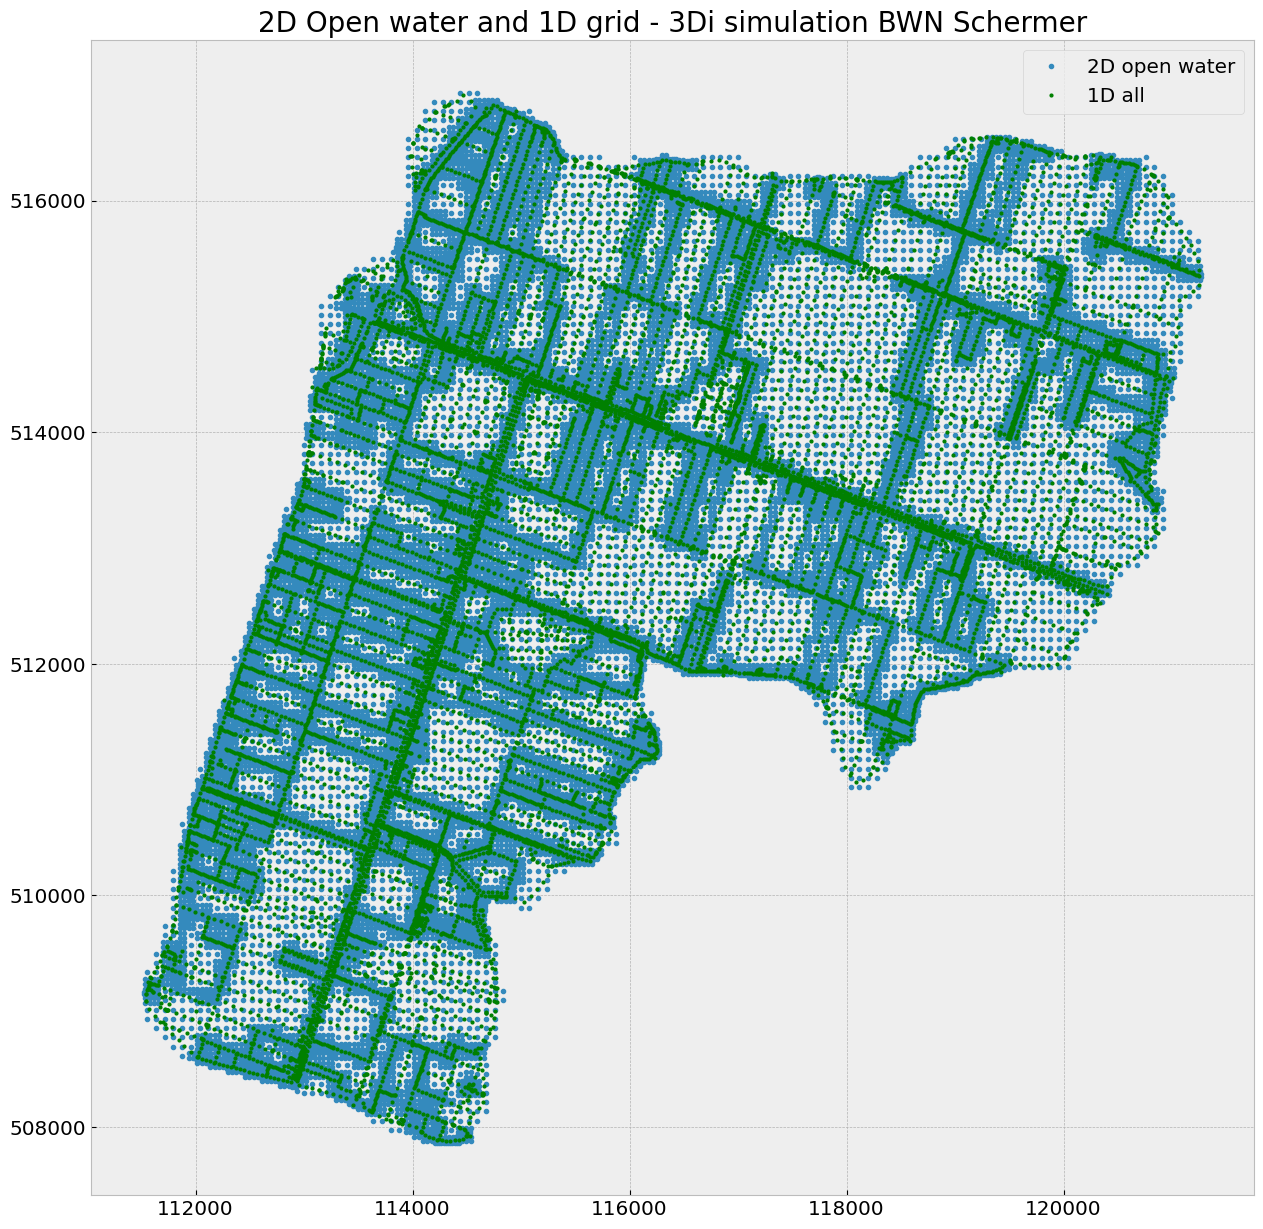

In [27]:
plt.figure()
#plotting only your 2d open water grid 
xyc = ga.nodes.subset('2d_open_water').coordinates
plt.plot(xyc[0], xyc[1], '.', label='2D open water')

#plotting your 1D grid
xyc = ga.nodes.subset('1D_ALL').coordinates
plt.plot(xyc[0], xyc[1], '.', label='1D all', color='green', markersize=4)

# Setting the axis right
plt.legend()
plt.axis('equal')
plt.axis('tight')
plt.title("2D Open water and 1D grid - 3Di simulation BWN Schermer", fontsize=20)

Let's plot the waterlevels at some points of the grid:

In [28]:
#see which nodes id's are available
print (ga.nodes.id)

# Select some nodes
sselect = [10000,20000, 30000, 40000]
sset = ga.nodes.filter(id__in=sselect)

[    0     1     2 ... 53380 53381 53382]


Text(0.5, 1.0, 'Overview of grid points where we would like to extract the waterlevel timeseries of the simulation')

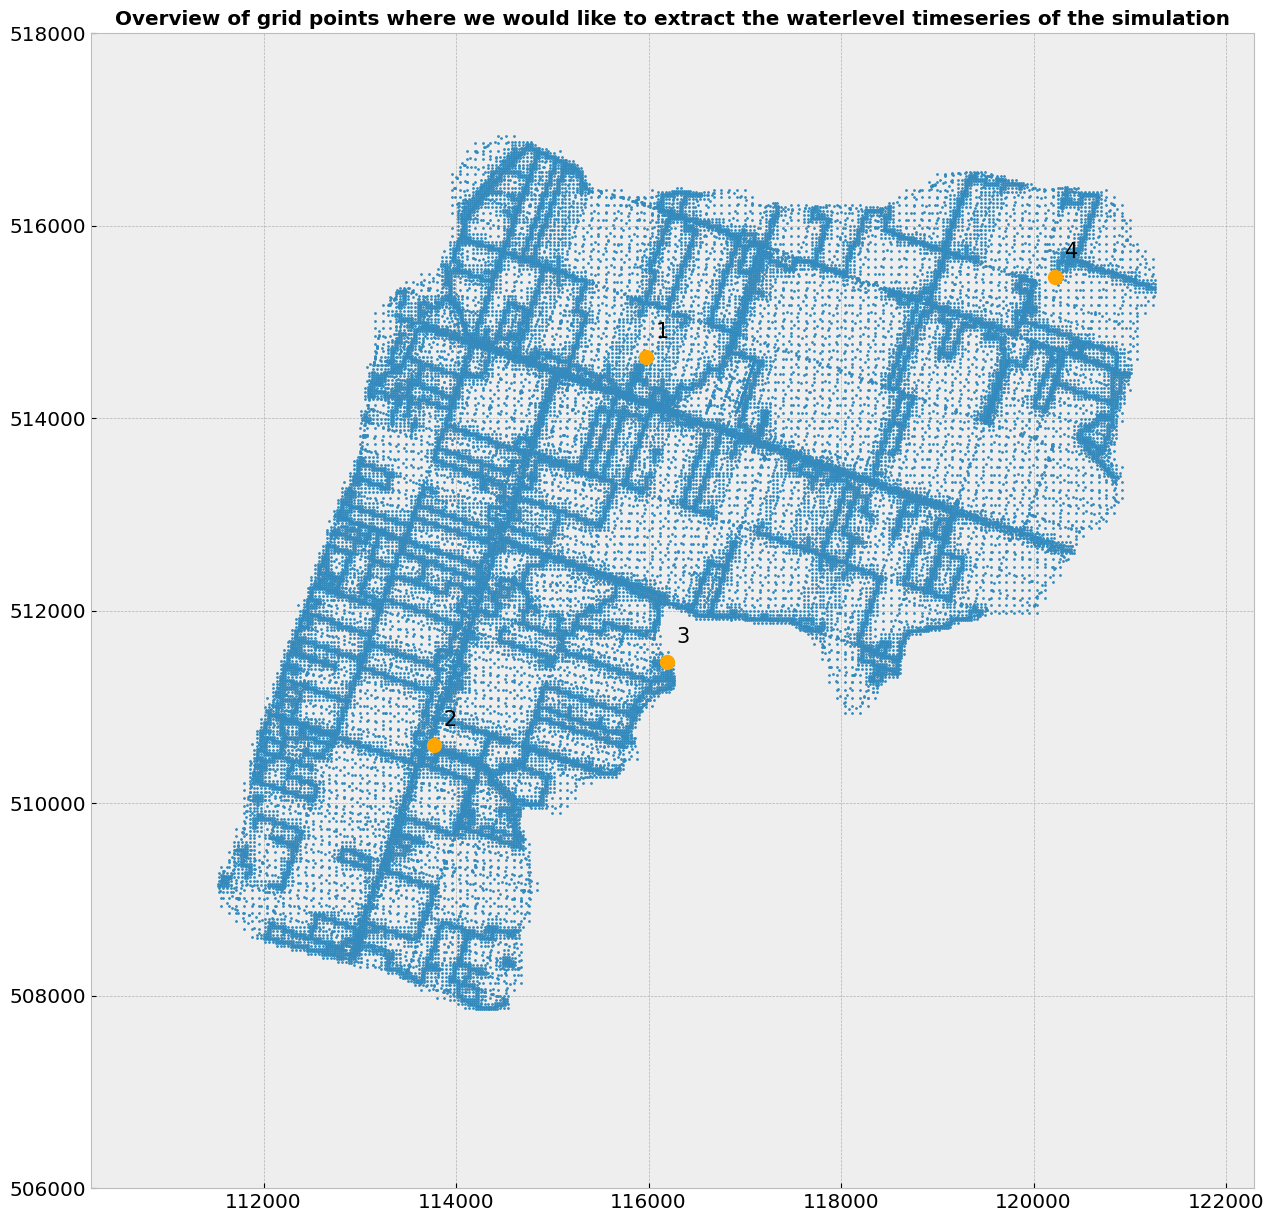

In [29]:
# Show in a plot where these nodes are in the model
plt.figure()
plt.plot(ga.nodes.coordinates[0], ga.nodes.coordinates[1], '.', markersize=2)

# and than your selection in red with extra large markers
plt.plot(sset.coordinates[0], sset.coordinates[1], '.', markersize=20, color='orange')
plt.text(sset.coordinates[0][0]+100, sset.coordinates[1][0]+200, '1', fontsize=15)
plt.text(sset.coordinates[0][1]+100, sset.coordinates[1][1]+200, '2', fontsize=15)
plt.text(sset.coordinates[0][2]+100, sset.coordinates[1][2]+200, '3', fontsize=15)
plt.text(sset.coordinates[0][3]+100, sset.coordinates[1][3]+200, '4', fontsize=15)
plt.axis('tight')
plt.axis('equal')

plt.xlim(110000, 122500)
plt.ylim(506000, 518000)

plt.title('Overview of grid points where we would like to extract the waterlevel timeseries of the simulation', fontweight='bold')

In [30]:
# Defining the time axis, within a time domain
ts = gr.nodes.timestamps[np.where((gr.nodes.timestamps >=0) & (gr.nodes.timestamps <= 7200))]
#Selecting the water levels based on your choice for domain and period.
s1_select = gr.nodes.filter(id__in=sselect).timeseries(start_time=0, end_time=7200).s1

Text(0.5, 1.0, 'Waterlevels at the different grid nodes - BWN Schermer')

<Figure size 1500x1500 with 0 Axes>

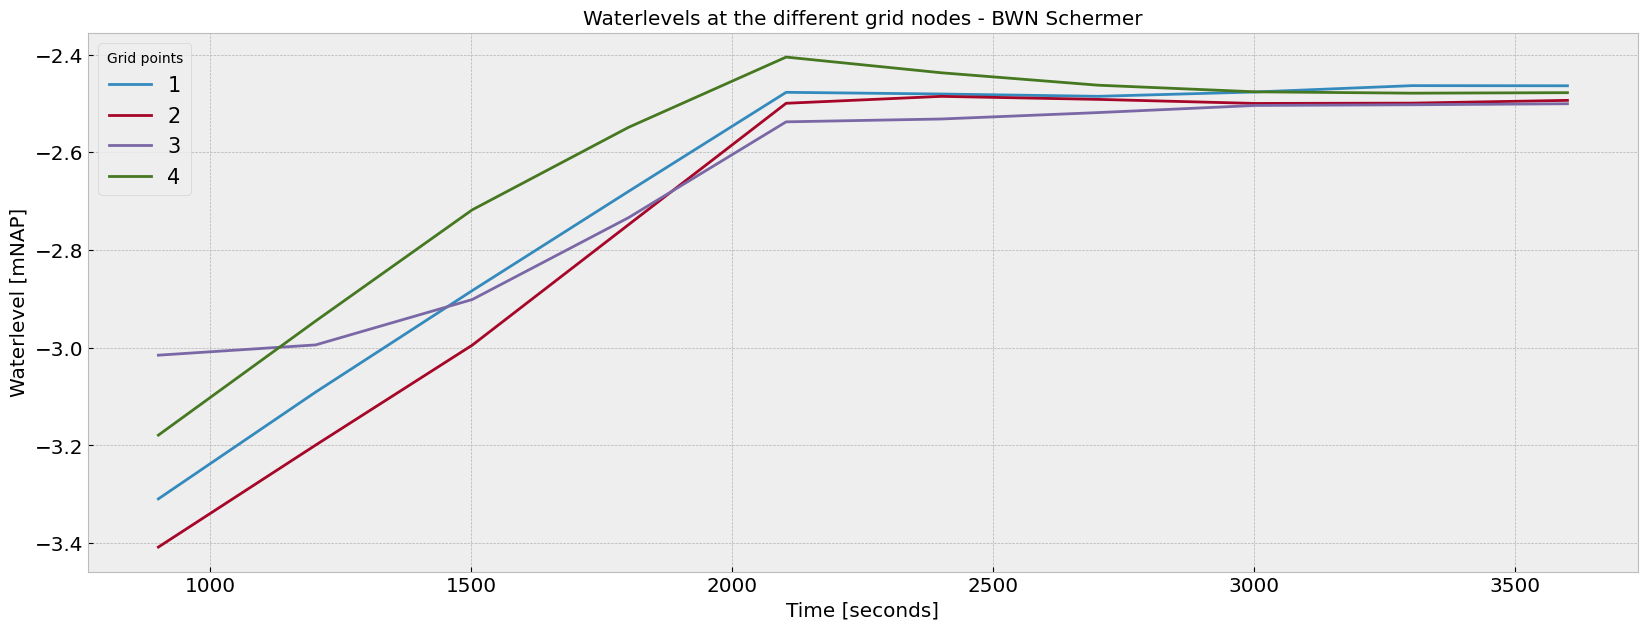

In [31]:
plt.figure(1)

# If you want to change the size and shape of only this figure
plt.figure(figsize=(20,7))

# Plotting the timeseries of your selection
plt.plot(ts[3:], s1_select[3:])

# Defining the legend based on the nodes of your selection
plt.legend(['1', '2', '3', '4'], frameon=True, fontsize=15, title='Grid points')

# Naming your axis
plt.xlabel('Time [seconds]')
plt.ylabel('Waterlevel [mNAP]')

# Title of your Figure
plt.title('Waterlevels at the different grid nodes - BWN Schermer')

Let's zoom in on a part of the model:

In [32]:
nodes_bbox = ga.nodes.filter(coordinates__in_bbox=[116005, 512000, 116010, 512250])

Text(0.5, 1.0, 'Zooming in on a part of the model - a certain cross section')

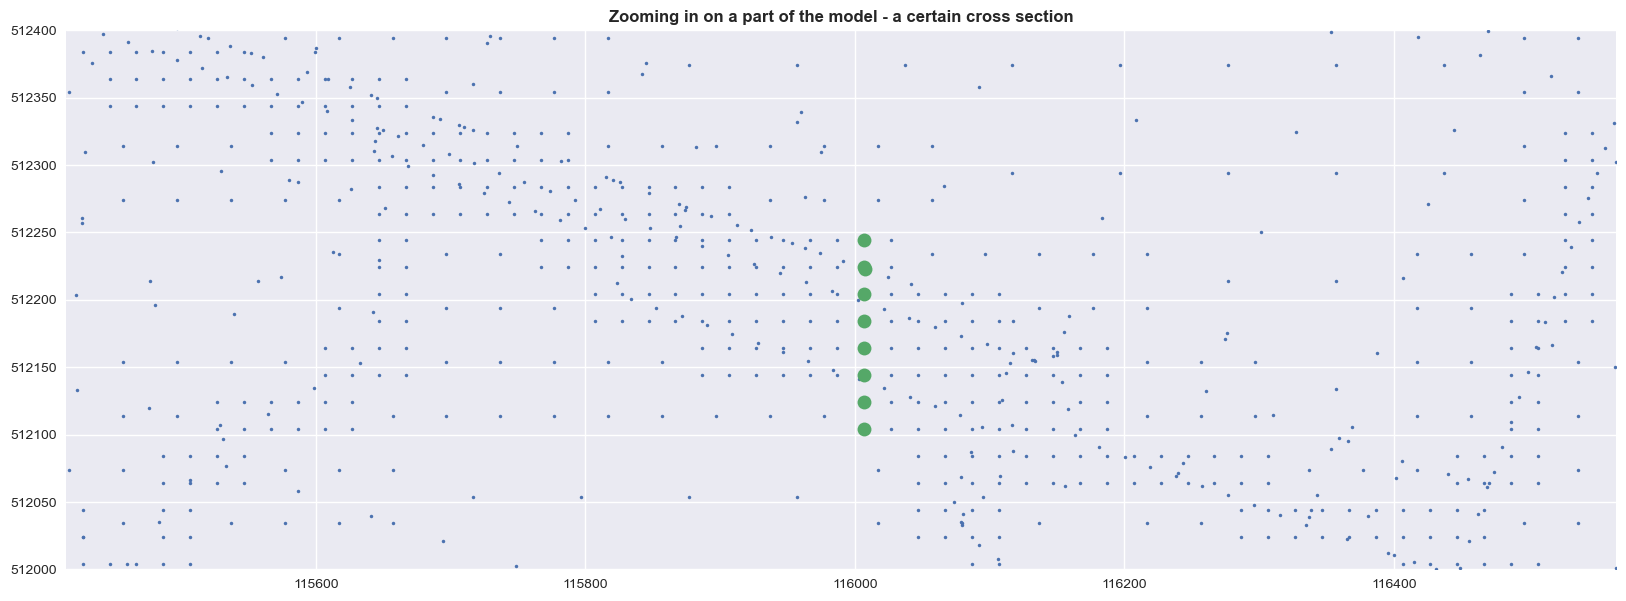

In [34]:
# Show in a plot where these nodes are in the model
plt.style.use('seaborn')
plt.figure(figsize=(20,7))
plt.plot(ga.nodes.coordinates[0], ga.nodes.coordinates[1], '.', markersize=5)

# and than your selection in red with extra large markers
plt.plot(nodes_bbox.coordinates[0], nodes_bbox.coordinates[1], '.', markersize=20)
plt.axis('tight')
plt.axis('equal')

plt.xlim(115980, 116000)
plt.ylim(512000, 512400)

plt.title('Zooming in on a part of the model - a certain cross section', fontweight='bold')

We have selected a certain cross section and now we can calcute the following parameters at the points within this cross-section. Note that there are a lot more parameters to calculate, but they wont be used in this analysis.

* velocity
* discharge
* ......



In [35]:
# Selecting the lines in this specific area
lines_bbox = ga.lines.filter(line_coords__in_bbox=[116005, 512000, 116010, 512250])

# Selecting only the highest indexes, to select only the velocities in the y-direction
yline_bbox = lines_bbox.filter(id__gt=4000)

In [36]:
# By selecting the coordinates of the lines, they give you the start and end location. One can for example compute the line centre
ycoor_line = lines_bbox.filter(id__gt=4000).line_coords[1]



In [37]:
# showing some results, for example variations of velocity over the width
line_select = yline_bbox.id

In [38]:
# checking number of times a result is saved
gr.lines.timestamps.shape

(13,)

There are 13 timestamps and the last timestamp is the one we are going to use for this analysis. Ofcourse, it is also possible to use other timestamps.

In [39]:
# Selecting the set of velocities and dischargers at final timestamp
uset = gr.lines.filter(id__in=line_select).timeseries(indexes=[12]).u1 #calculate velocity at last timestamp
qset = gr.lines.filter(id__in=line_select).timeseries(indexes=[12]).q #calculate discharge at last timestamp


Text(0, 0.5, 'Y-coordinate')

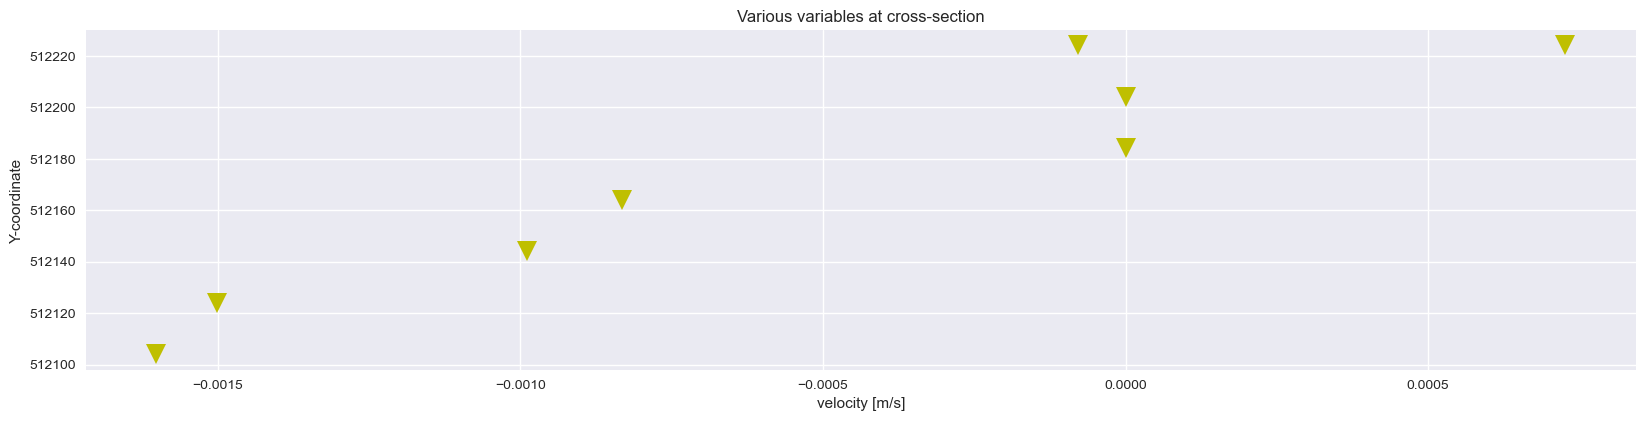

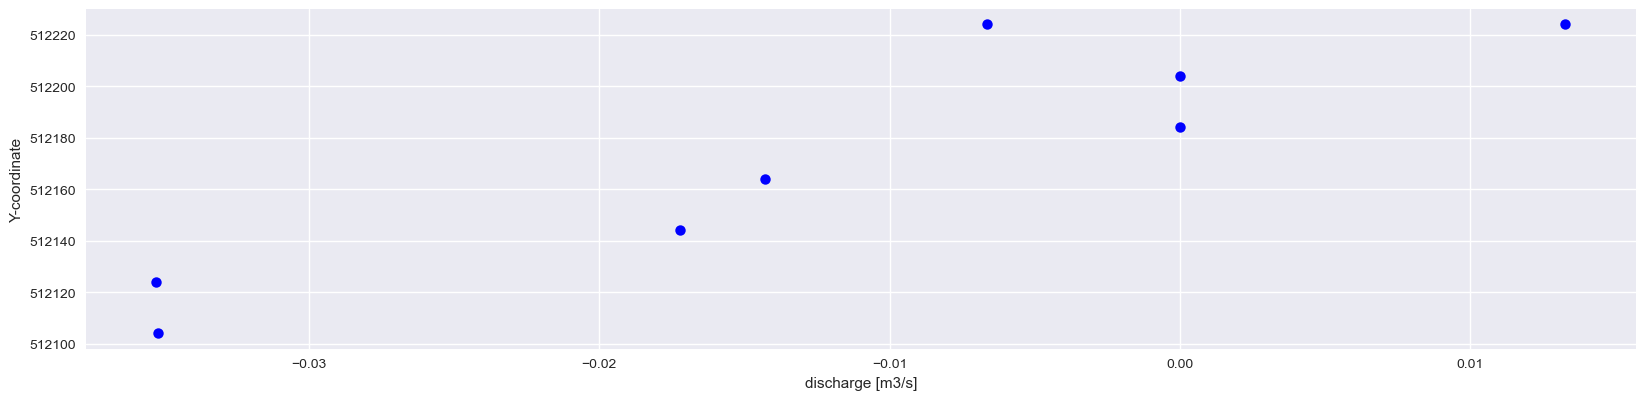

In [40]:
#Plotting the combined results of velocity, discharge and wet cross-sectional area
plt.figure(1,  figsize=(20,15))
plt.subplot(311)
plt.plot(uset[0], ycoor_line, 'yv',markersize=15)
plt.xlabel('velocity [m/s]')
plt.ylabel('Y-coordinate')
plt.title('Various variables at cross-section')


plt.figure(2,  figsize=(20,15))
plt.subplot(312)
plt.plot(qset[0], ycoor_line, 'b.',markersize=15)
plt.xlabel('discharge [m3/s]')
plt.ylabel('Y-coordinate')


**-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**
The end

In this tutorial we showed you:
- how to start a simulation of a 3Di-model, 
- how to add a simple rain event to your simulation, 
- how to download the results of the model simulation,
- and in the end how to visualise your model and how to use threedigrid to do any analysis on the results.

And all possible within a Jupyter notebook by making use of the API-v3. Ofcourse there are a lot more options for the analysis possible, by using threedigrid. Or for the events you can add to your simulation. Do you want to learn more or are you interested in some more possible analysis in a jupyter notebook? 

**Please contact**:

Olof Baltus | olof.baltus@nelen-schuurmans.nl

Jonas van Schrojenstein | jonas.vanschrojenstein@nelen-schuurmans.nl
